# Exercise 4: recommender System

In [1]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/keuperj/DataScienceSS20.git
  path='DataScienceSS20'

running in Colab: False


## Code from the lecture

In [2]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(path+'/DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(path+'/DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(path+'/DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [15]:
def getTopN(movie_id,D,N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title)))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [16]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [17]:
#cosine distance from lecture
import scipy.spatial
D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='cosine'))
D=np.abs(np.nan_to_num( D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [18]:
#Euclidean
DL2=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='euclidean'))
DL2=np.abs(np.nan_to_num( DL2-np.max(DL2))) 
np.fill_diagonal(DL2,0)

In [19]:
#Correlation
Dcor=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='correlation'))
Dcor=np.abs(np.nan_to_num( Dcor-1)) 
np.fill_diagonal(Dcor,0)

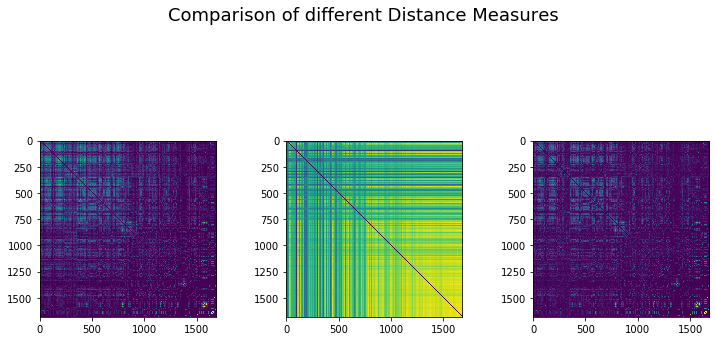

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.suptitle('Comparison of different Distance Measures', fontsize=18)
for i in range (1, 4):
    ax = fig.add_subplot(2, 3, i)
    if i == 1:
        plt.imshow(D)
    if i == 2:
        plt.imshow(DL2)
    if i == 3:
        plt.imshow(Dcor)
plt.show()

## 4.2 Baseline Results
Implement and compare results of
* random recommendations
* allways recommending the top 5 movies (over all users)

In [21]:
from sklearn.model_selection import train_test_split
R_train, R_test = train_test_split(R, test_size=0.1)

#cosine distance from lecture
import scipy.spatial
D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='cosine'))
D=np.abs(np.nan_to_num( D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero
#Euclidean
DL2=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='euclidean'))
DL2=np.abs(np.nan_to_num( DL2-np.max(DL2))) 
np.fill_diagonal(DL2,0)
#Correlation
Dcor=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='correlation'))
Dcor=np.abs(np.nan_to_num( Dcor-1)) 
np.fill_diagonal(Dcor,0)


In [30]:
test_D=test_Score(D,R_test)
test_DL2=test_Score(DL2,R_test)
test_Dcor=test_Score(Dcor,R_test)

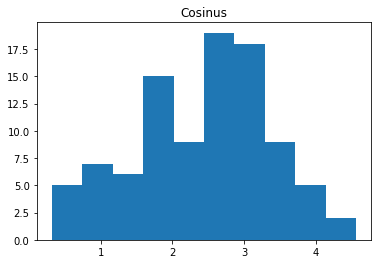

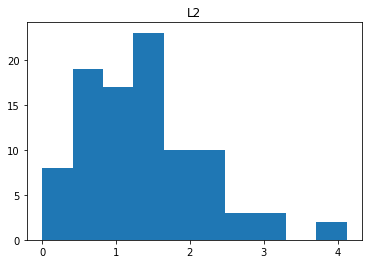

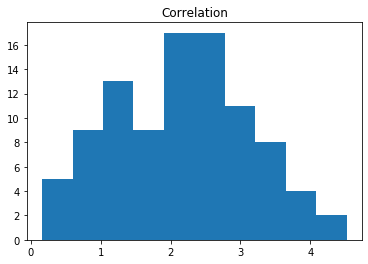

In [35]:
plt.hist(test_D)
plt.title('Cosinus')
plt.show()
plt.hist(test_DL2)
plt.title('L2')
plt.show()
plt.hist(test_Dcor)
plt.title('Correlation')
plt.show()

## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $R$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct R and evaluate $R'$
* compute the distance between two movies using $R'$

In [51]:
u,s,v = np.linalg.svd(R_train)

In [52]:
R_train.shape, u.shape, s.shape, v.shape

((848, 1682), (848, 848), (848,), (1682, 1682))

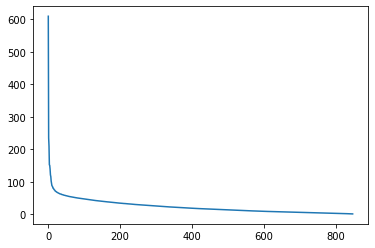

In [53]:
plt.plot(s)
plt.show()

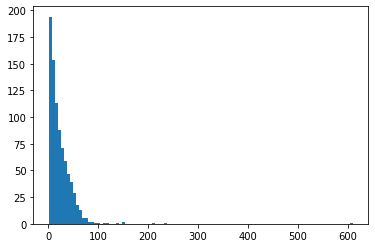

In [54]:
t=plt.hist(s,bins=100)

In [55]:
np.allclose(R_train, np.dot(u * s, v[:848,:])) 

True

In [56]:
cut = 10
R_approx = np.dot(u [:,:cut] * s[:cut], v[:cut,:])

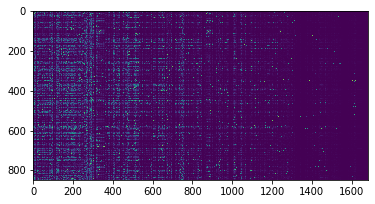

In [57]:
plt.imshow(np.abs(R_train-R_approx))
plt.show()

In [58]:
D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_train.T, metric='cosine'))
D=np.abs(np.nan_to_num( D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero

Dapprox=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_approx.T, metric='cosine'))
Dapprox=np.abs(np.nan_to_num( Dapprox-1)) #dist to similarity 
np.fill_diagonal(Dapprox,0) #set self-dist to zero

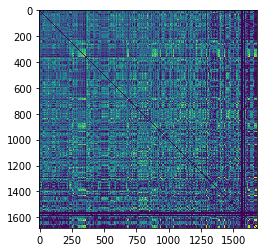

In [61]:
plt.imshow(np.abs(D-Dapprox))
plt.show()

In [71]:
test_Dapprox=test_Score(Dapprox,R_test)

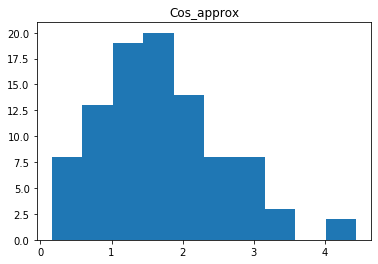

In [72]:
plt.hist(test_Dapprox)
plt.title('Cos_approx')
plt.show()